# Big Data Application: Modeling for Crop Yield Estimation

This jupyter notebook is addressed for creating model that can estimate crop yield in North Dakota, United States. The detail workflow of this project can be seen in [here](https://drive.google.com/file/d/1u3jHTnLqoxMca7SRzgnvGjP-iBvfTnls/view?usp=sharing).

## 0. Install & Load Packages

In [7]:
#install packages
!pip install tensorflow

In [9]:
#load packages

import pandas as pd
from sklearn.preprocessing import StandardScaler

#packages for manipulating dataframe
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import sklearn

#packages for machine learning
##train-test-split
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve

##method 1: Linear Regression (LR)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

##method 2: Random Forest Regressor (RF)
import rfpimp
from sklearn.ensemble import RandomForestRegressor

##method 3: Gradient Boosting Regressor (XGB)
import xgboost
from xgboost import XGBRegressor

##method 4: Artificial Neural Network (ANN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##cross validation

##evaluation metrics (R2 and RMSE)
from sklearn.metrics import r2_score, mean_squared_error

#data visualization
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

## 1. Load & Cleaning Data

In [10]:
#load data
wheat_2018 = pd.read_csv('https://www.dropbox.com/scl/fi/qyk0rjcvay0azb6k3cxzf/wheat_2018.csv?rlkey=1vmvrf6o9jiik4tsjax68ps7b&dl=1')
wheat_2019 = pd.read_csv('https://www.dropbox.com/scl/fi/g5vws0nge1drxu675fb92/wheat_2019.csv?rlkey=fq5h3fjuz5n9qgmcef9khlcan&dl=1')
wheat_2020 = pd.read_csv('https://www.dropbox.com/scl/fi/xczuhmh4l66fcci6hdltu/wheat_2020.csv?rlkey=vkdy66mfbjd5dxr657uew2uxn&dl=1')
wheat_2021 = pd.read_csv('https://www.dropbox.com/scl/fi/8swbr3pbosrx52tq5s1xr/wheat_2021.csv?rlkey=j74dzta87987vnaprsdr0fjtx&dl=1')
wheat_2022 = pd.read_csv('https://www.dropbox.com/scl/fi/9m8c7iu1wc07ispw2vhy3/wheat_2022.csv?rlkey=101ujmr4w4v0tv2stm4kr8z5u&dl=1')
wheat_2023 = pd.read_csv('https://www.dropbox.com/scl/fi/eq4rmh61kr1oolm1txe2p/wheat_2023.csv?rlkey=yldyhdickfvnpm7ssv3lx6d55&dl=1')

In [11]:
wheat_list = [wheat_2018, wheat_2019, wheat_2020, wheat_2021, wheat_2022, wheat_2023]
wheat_df = pd.concat(wheat_list)
# wheat_df = wheat_df.drop(['NAME','GEOID'], axis=1)
# Precipitation; LST_DAY ; Soil_Moisture_am
wheat_df = wheat_df.drop(['NAME','GEOID','Precipitation','LST_DAY','Soil_Moisture_am'], axis=1)
wheat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318 entries, 0 to 52
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Yield             318 non-null    float64
 1   ET                318 non-null    float64
 2   LST_NIGHT         318 non-null    float64
 3   NDVI              318 non-null    float64
 4   PAR               318 non-null    float64
 5   SAR               318 non-null    float64
 6   Soil_Moisture_pm  318 non-null    float64
dtypes: float64(7)
memory usage: 19.9 KB


In [5]:
# 导出 DataFrame 到 CSV 文件
wheat_df.to_csv('wheat.csv', index=False)

<Axes: >

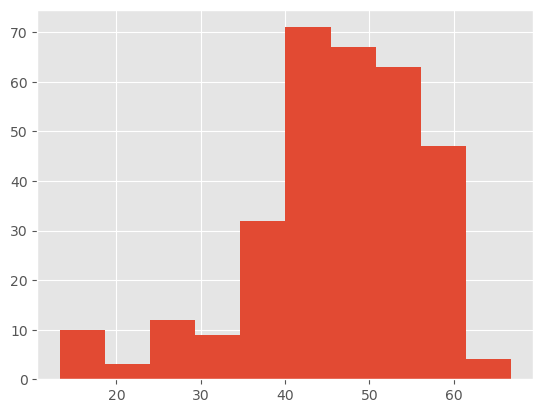

In [12]:
wheat_df.Yield.hist()

Text(0.5, 1.0, 'Correlation Matrix')

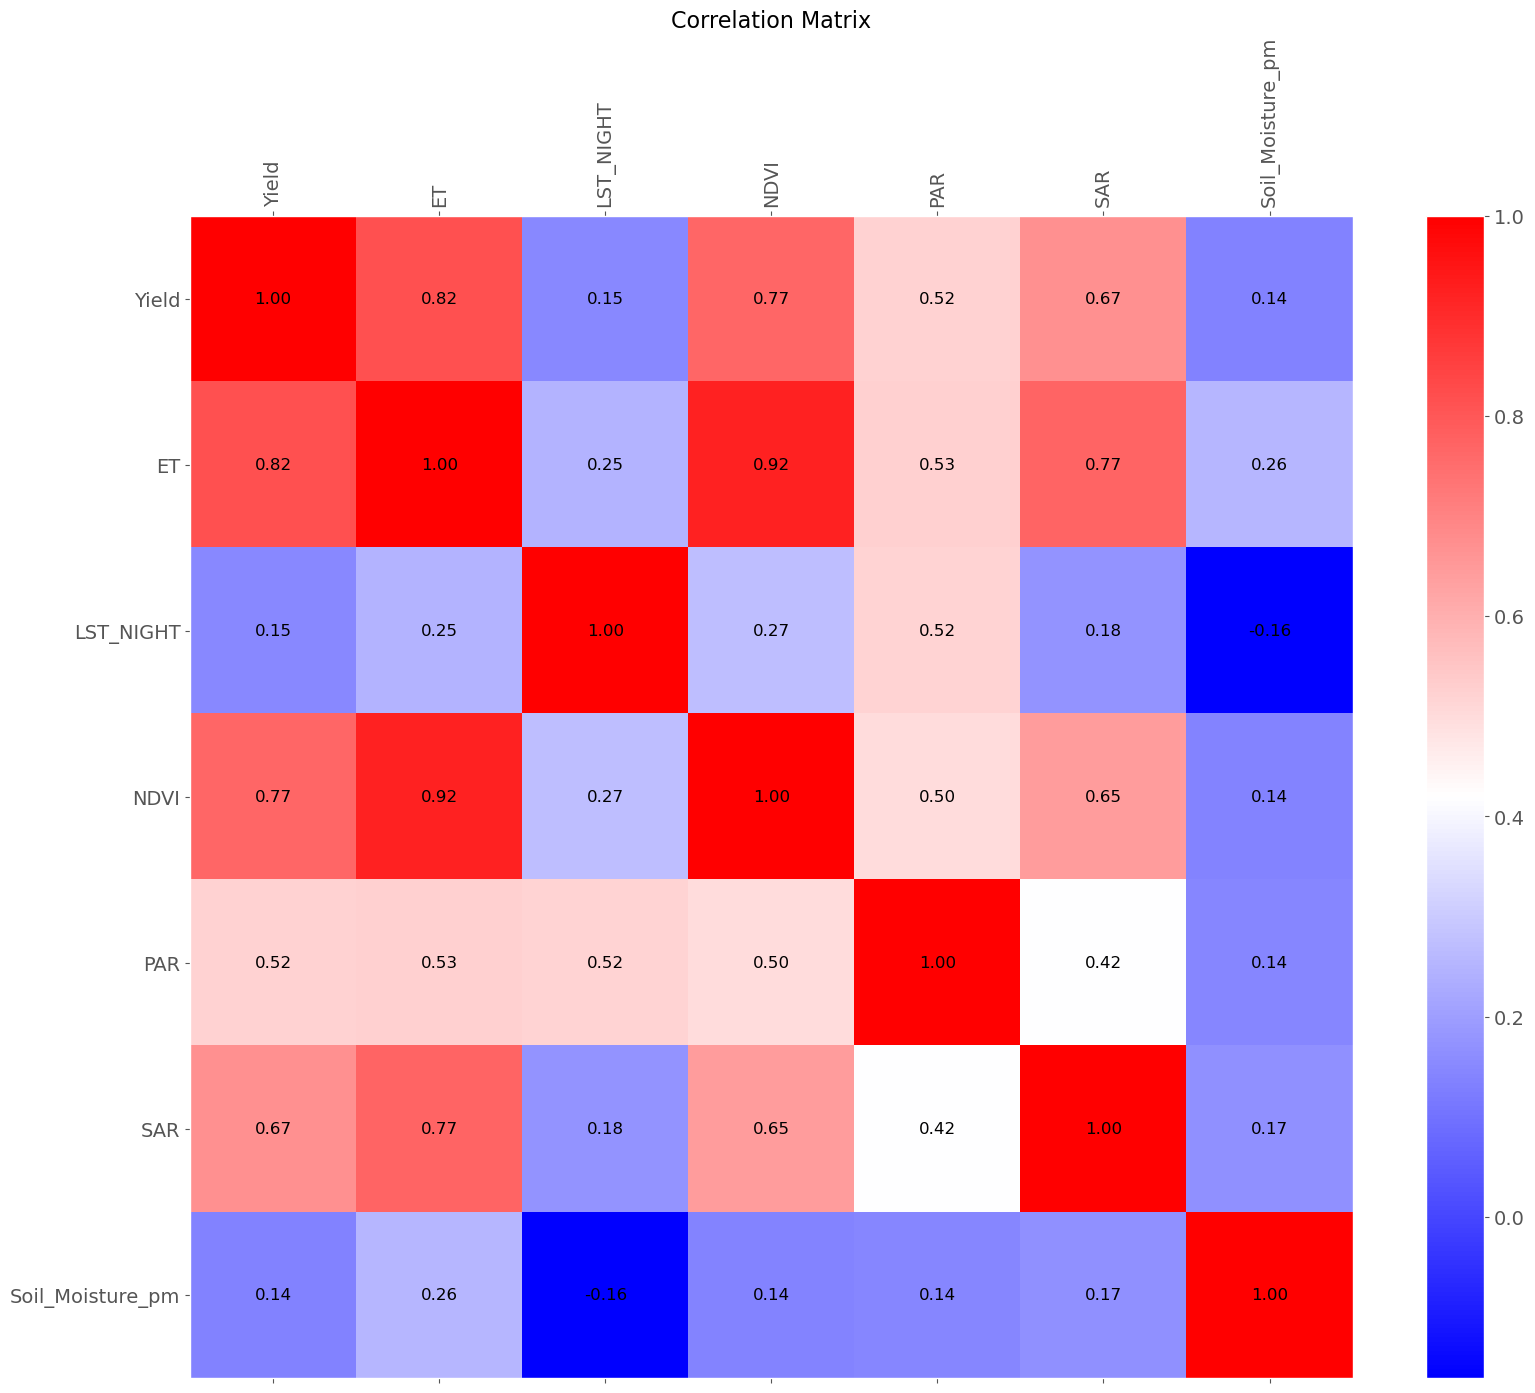

In [13]:
# Correlation coefficients
correlation_matrix = wheat_df.corr()

plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(wheat_df.corr(), fignum=f.number,cmap='bwr')
plt.xticks(range(wheat_df.shape[1]), wheat_df.columns, fontsize=14, rotation=90)
plt.yticks(range(wheat_df.shape[1]), wheat_df.columns, fontsize=14)

for i in range(wheat_df.shape[1]):
    for j in range(wheat_df.shape[1]):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', fontsize=12, color='black')

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.savefig('correlation_matrix_soybean.png', bbox_inches='tight')

plt.title('Correlation Matrix', fontsize=16)

## 2.1 Train & Test Data Split

In [14]:
#split the dataset
X = wheat_df.drop('Yield', axis=1)
y = wheat_df['Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)

## 2.2 Train & Test Data Standarderlized

In [15]:
def standardize_columns(file_name, columns_to_standardize):
    scaler = StandardScaler()

    df = file_name
    df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
    return df

def standardize_series(series):
    scaler = StandardScaler()
    series = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()
    return series
    
# X_columns = ['ET','LST_DAY','LST_NIGHT','NDVI','Precipitation', 'PAR','SAR', 'Soil_Moisture_am','Soil_Moisture_pm']
# Soil_Moisture_am
X_columns = ['ET','LST_NIGHT','NDVI', 'PAR','SAR','Soil_Moisture_pm']
y_columns = ['Yield']

X_train = standardize_columns(X_train, X_columns)
X_test = standardize_columns(X_test, X_columns)

# y_train = standardize_series(y_train)
# y_test = standardize_series(y_test)

## 3. Model Training and Parameter Tuning

### 3.1. Linear Regression (LR)

In [16]:
model_lr = LinearRegression()

# Cross validation
scores = cross_val_score(model_lr, X, y, cv=5, scoring='neg_mean_squared_error')

mean_mse = np.mean(scores)
std_mse = np.std(scores)

print(f'Mean MSE: {mean_mse}')
print(f'Standard Deviation of MSE: {std_mse}')

Mean MSE: -34.518798672878525
Standard Deviation of MSE: 9.445061469649747


In [17]:
model_lr.fit(X_train, y_train)

LinearRegression()

### 3.2. Random Forest Regressor (RF)

In [18]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[3,5,10,20,30], 'min_samples_split':[2,4,6,8,10]}


randomState_dt = 10000
model_rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(model_rf, hyperparameters)

clf.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

The best parameter value is: 
{'max_depth': 10, 'min_samples_split': 10}
The best score is: 
0.6888061371401578


In [19]:
# Train the final RF
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=10000)

### 3.3. Gradient Boosting Regressor (XGB)

In [142]:
import warnings

# 设置忽略 FutureWarning 类型的警告
warnings.simplefilter(action='ignore', category=FutureWarning)

In [143]:
# model_xgb =
# soybean_df

# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[2,4,6,8,10], 'n_estimators':[4,8,12,16,20]}

randomState_xgb = 125
xgb = XGBRegressor(random_state=randomState_xgb)

# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters)

gscv_xgb.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (gscv_xgb.best_params_)
print ("The best score is: ")
print (gscv_xgb.best_score_)

The best parameter value is: 
{'max_depth': 8, 'n_estimators': 20}
The best score is: 
0.9923195499625839


### 3.4. Artificial Neural Network (ANN)

In [144]:
model_ann = keras.Sequential([
    layers.Input(shape=(9,)),  # Input layer
    layers.Dense(128, activation='relu'),  # Hidden layer with ReLU activation
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(64, activation='relu'),  # Additional hidden layer
    layers.Dropout(0.3),  # Another dropout layer
    layers.Dense(1)  # Output layer
])

#measuring the training with certain metrics
model_ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [145]:
#train the model
model_ann.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0000e+00 - loss: 2348.2444 - val_accuracy: 0.0000e+00 - val_loss: 2294.2520
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 2315.0215 - val_accuracy: 0.0000e+00 - val_loss: 2212.4778
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 2237.3042 - val_accuracy: 0.0000e+00 - val_loss: 2111.4783
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 2096.6111 - val_accuracy: 0.0000e+00 - val_loss: 1978.4889
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 1977.5494 - val_accuracy: 0.0000e+00 - val_loss: 1804.2450
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 1767.3147 - val_accuracy: 0.0000e+00 - val_loss: 1587.7260
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 1484.5956 - val_accuracy: 0.0000e+00 - val_loss: 1332.4340
Epoch 8/100
8/8 ━━━━━━━━━━

## 4. Model Evaluation and Performance Comparison

Comparing the performance with using R2 and Root Mean Squared Error (RMSE).

### 4.1. E. Linear Regression (LR)

In [20]:
# 获取回归模型的参数
intercept = model_lr.intercept_  # 截距
coefficients = model_lr.coef_     # 系数，一个数组，每个元素对应一个自变量的系数

print("截距:", intercept)
print("系数:", coefficients)

截距: 45.905462184873954
系数: [ 5.32238802 -2.01864622  1.53505427  2.1144597   1.69548912 -1.08028928]


In [21]:
# 构建模型表达式 Building intercept
expression = f"Y = {intercept}"
for i, (coef, var) in enumerate(zip(coefficients, X_columns)):
    expression += f" + {coef} * {var}"
print(expression)

Y = 45.905462184873954 + 5.322388021624736 * ET + -2.018646216101594 * LST_NIGHT + 1.535054270985625 * NDVI + 2.114459697962808 * PAR + 1.6954891221007127 * SAR + -1.080289281473687 * Soil_Moisture_pm


In [22]:
train_predictions = model_lr.predict(X_train)
test_predictions = model_lr.predict(X_test)

r2_train_lr = r2_score(y_train, train_predictions)
r2_test_lr = r2_score(y_test, test_predictions)

rmse_train_lr = mean_squared_error(y_train, train_predictions, squared=False)
rmse_test_lr = mean_squared_error(y_test, test_predictions, squared=False)

print(f"Training R^2: {r2_train_lr:.4f}")
print(f"Test R^2: {r2_test_lr:.4f}")
print(f"Training RMSE: {rmse_train_lr:.4f}")
print(f"Test RMSE: {rmse_test_lr:.4f}")

Training R^2: 0.7082
Test R^2: 0.7042
Training RMSE: 5.5595
Test RMSE: 5.2984


### 4.2. E. Random Forest Regressor (RF)

In [23]:
r2_train_rf = rf_final.score(X=X_train, y=y_train)
r2_test_rf = rf_final.score(X=X_test, y=y_test)

print("R2 on the training data:")
print(r2_train_rf)
print("R2 on the testing data:")
print(r2_test_rf)

R2 on the training data:
0.9113651707234036
R2 on the testing data:
0.7361749954189063


In [24]:
rmse_train_rf = mean_squared_error(y_train, rf_final.predict(X_train), squared=False)
rmse_test_rf = mean_squared_error(y_test, rf_final.predict(X_test), squared=False)

print("RMSE on the training data:")
print(rmse_train_rf)
print("RMSE on the testing data:")
print(rmse_test_rf)

RMSE on the training data:
3.0640939019361295
RMSE on the testing data:
5.003729396744494


                                               Importance
Feature                                                  
ET                                                 0.3649
NDVI                                               0.1915
PAR                                                0.0944
SAR                                                0.0794
LST_NIGHT                                         -0.0082
Soil_Moisture_pm                                  -0.0130


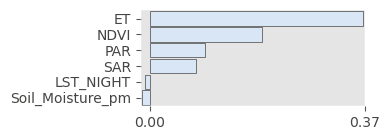

In [25]:
# Calculate and plot the feature importance of the RF model
imp = rfpimp.importances(rf_final, X_test, y_test)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### 4.3. E. Gradient Boosting Regressor (XGB)

In [150]:
model_xgb = XGBRegressor(max_depth=gscv_xgb.best_params_['max_depth'], n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=randomState_xgb)
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=125, ...)

In [151]:
# r2_train_xgb, r2_test_xgb, rmse_train_xgb, rmse_test_xgb
r2_train_xgb = model_xgb.score(X=X_train, y=y_train)
r2_test_xgb = model_xgb.score(X=X_test, y=y_test)
rmse_train_xgb = mean_squared_error(y_train, model_xgb.predict(X_train), squared=False)
rmse_test_xgb = mean_squared_error(y_test, model_xgb.predict(X_test), squared=False)

In [152]:
print("R2 on the training data:")
print(r2_train_xgb)
print("R2 on the testing data:")
print(r2_test_xgb)

R2 on the training data:
0.9999906705962772
R2 on the testing data:
0.6211699630764378


In [153]:
print("RMSE on the training data:")
print(rmse_train_xgb)
print("RMSE on the testing data:")
print(rmse_test_xgb)

RMSE on the training data:
0.020644560160876076
RMSE on the testing data:
4.23536556078444


                                               Importance
Feature                                                  
PAR                                                0.8349
SAR                                                0.1441
NDVI                                               0.1151
Soil_Moisture_am                                   0.1071
LST_DAY                                            0.0284
Precipitation                                      0.0018
Soil_Moisture_pm                                  -0.0020
ET                                                -0.0084
LST_NIGHT                                         -0.0136


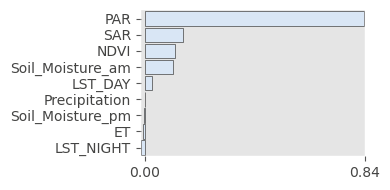

In [154]:
imp_xgb = rfpimp.importances(model_xgb, X_test, y_test) # permutation
print(imp_xgb)
viz_xgb = rfpimp.plot_importances(imp_xgb)
viz_xgb.view()

### 4.4. E. Artificial Neural Network (ANN)

In [157]:
#predictions
y_pred_train_ann = model_ann.predict(X_train).flatten()
y_pred_test_ann = model_ann.predict(X_test).flatten()

#Compute R2 and RMSE
r2_train_ann = np.round(r2_score(y_train, y_pred_train_ann),2)
r2_test_ann = np.round(r2_score(y_test, y_pred_test_ann),2)
rmse_train_ann = np.round(np.sqrt(mean_squared_error(y_train, y_pred_train_ann)),2)
rmse_test_ann = np.round(np.sqrt(mean_squared_error(y_test, y_pred_test_ann)),2)

#print the result
print("Train R2:", r2_train_ann)
print("Test R2:", r2_test_ann)
print("Train RMSE:", rmse_train_ann)
print("Test RMSE:", rmse_test_ann)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train R2: 0.34
Test R2: 0.32
Train RMSE: 5.51
Test RMSE: 5.69


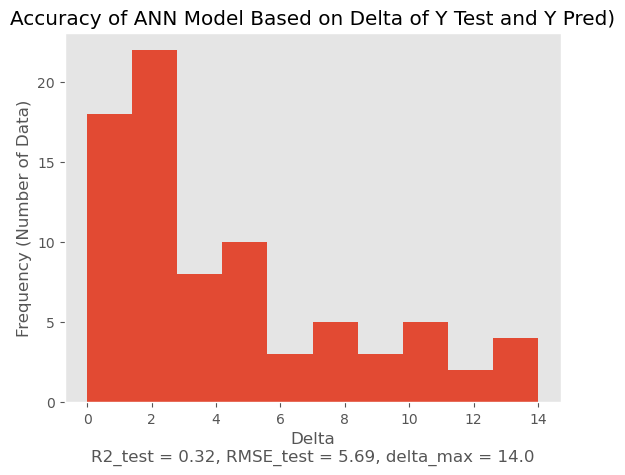

In [158]:
#crosscheck the y value between real and predicted
crosscheck_y_dict = {
    'y_test' : y_test,
    'y_pred' : np.round(y_pred_test_ann,0),
    'delta' : np.abs(np.round((y_test - y_pred_test_ann),0))
}

#plotting histogram
crosscheck_y_df = pd.DataFrame(crosscheck_y_dict)
plt.hist(crosscheck_y_df['delta'], bins=10)
plt.xlabel(f'Delta\nR2_test = {r2_test_ann}, RMSE_test = {rmse_test_ann}, delta_max = {crosscheck_y_df.delta.max()}')
plt.ylabel('Frequency (Number of Data)')
plt.title(f"Accuracy of ANN Model Based on Delta of Y Test and Y Pred)")
plt.show()

### 4.5. Model Performance Comparison

In [27]:
#please input your metrics in here
metrics_dict = {
    'metrics': ["Train R2","Test R2","Train RMSE","Test RMSE"],
    'LR': [r2_train_lr, r2_test_lr, rmse_train_lr, rmse_test_lr],
    'RF': [r2_train_rf, r2_test_rf, rmse_train_rf, rmse_test_rf],
#    'XGB': [r2_train_xgb, r2_test_xgb, rmse_train_xgb, rmse_test_xgb],
#    'ANN': [r2_train_ann, r2_test_ann, rmse_train_ann, rmse_test_ann]
}

#create dataframe
metrics_df = pd.DataFrame(metrics_dict)
metrics_df.set_index('metrics')

,LR,RF
metrics,,
Train R2,0.7082,0.9114
Test R2,0.7042,0.7362
Train RMSE,5.5595,3.0641
Test RMSE,5.2984,5.0037


Based on the comparison, it can be said that the best model that can be used for estimating crop yield is []. From this point, [] model would be used for estimation phase (step 5).

## 5. Crop Yield Estimation and Export Result